# Notebook para treinamento de modelo Machine Learning
## MVP Puc Rio - Lucas Rodrigues de Castro


### Descrição do projeto
Para o MPV foi escolhido utilizar um dataset com dados de processos de recrutamento para a predição se o candidato será ou não contratado.

As informações do Dataset podem ser encontradas no repositório do Kaggle, com as referencias de sua autoria e especificações. O Link a seguir é do dataset original.

Para finalidade do projeto o dataset foi copiado integralmente e sem alteração, armazenado em um repositório do github, pra facilitar a avaliação necessária. Qualquer outro uso deverá seguir as especificações do repositório original bem como mencionar a autoria de Rabie El Kharoua.

O dataset original foi gerado para fins didáticos.

https://www.kaggle.com/datasets/rabieelkharoua/predicting-hiring-decisions-in-recruitment-data

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Carregamento do Dataset

Utilizando um repositório do github que armazena o dataset , lemos o arquivo e cargamos em uma variável `dataset`.

É feito uma leitura das primeiras linhas para simples conferência do carregamento dos dados.

As especificações das colunas são:

- Age  
Description: Age of the candidate.  
Data Range: 20 to 50 years.  
Data Type: Integer.  

- Gender  
Description: Gender of the candidate.  
Categories: Male (0) or Female (1).  
Data Type: Binary.  

- Education Level  
Description: Highest level of education attained by the candidate.  
Categories:  
1: Bachelor's (Type 1)  
2: Bachelor's (Type 2)  
3: Master's  
4: PhD  
Data Type: Categorical.  

- Experience Years  
Description: Number of years of professional experience.  
Data Range: 0 to 15 years.  
Data Type: Integer.  

- Previous Companies Worked  
Description: Number of previous companies where the candidate has worked.  
Data Range: 1 to 5 companies.  
Data Type: Integer.  

- Distance From Company  
Description: Distance in kilometers from the candidate's residence to the hiring company.  
Data Range: 1 to 50 kilometers.  
Data Type: Float (continuous).  

- Interview Score  
Description: Score achieved by the candidate in the interview process.  
Data Range: 0 to 100.  
Data Type: Integer.  

- Skill Score  
Description: Assessment score of the candidate's technical skills.  
Data Range: 0 to 100.  
Data Type: Integer.  

- Personality Score  
Description: Evaluation score of the candidate's personality traits.  
Data Range: 0 to 100.  
Data Type: Integer.  

- Recruitment Strategy  
Description: Strategy adopted by the hiring team for recruitment.  
Categories:  
1: Aggressive  
2: Moderate  
3: Conservative  
Data Type: Categorical.  

- Hiring Decision (Target Variable)  
Description: Outcome of the hiring decision.  
Categories:  
0: Not hired  
1: Hired  
Data Type: Binary (Integer).  

### Dataset Information
- Records: 1500
- Features: 10
- Target Variable: HiringDecision (Binary)



In [ ]:
# Carga do Dataset
# dataset original utilizado https://www.kaggle.com/datasets/rabieelkharoua/predicting-hiring-decisions-in-recruitment-data

# Informa a URL de importação do dataset de um repositório GitHub
url = "https://raw.githubusercontent.com/lucas-rodrigues0/dataset_recruitment_data/main/recruitment_data.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


### Exibe informações sobre o dataset

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


## Holdout

Faz a separação de parte do dataset para a utilização no treino do modelo e parte para o teste posterior ao treinamento.

É utilizado 20% do dataset para o holdout de teste.  
O holdout é feito com a estratificação e validação cruzada para garantir a proporcionalidade dos dados no teste como no treinamento.

In [ ]:
# Separação em conjunto de treino e conjunto de teste com holdout

test_size = 0.2
seed = 7

arr = dataset.values
X = arr[:,0:10]
y = arr[:,10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

scoring = 'accuracy'
num_partitions = 10

kfold = StratifiedKFold(n_splits=num_partitions, shuffle=True, random_state=seed)

## Modelos linha de base

Cria modelos em uma linha base para fazer uma primeira avaliação dos possíveis modelos de classificação.

LR: 0.865833 (0.022189)
KNN: 0.686667 (0.013540)
CART: 0.869167 (0.043309)
NB: 0.865000 (0.018930)
SVM: 0.706667 (0.020683)
Bagging: 0.917500 (0.032798)
RF: 0.914167 (0.027399)
ET: 0.886667 (0.023333)
Ada: 0.876667 (0.033500)
GB: 0.929167 (0.015921)
Voting: 0.877500 (0.022376)


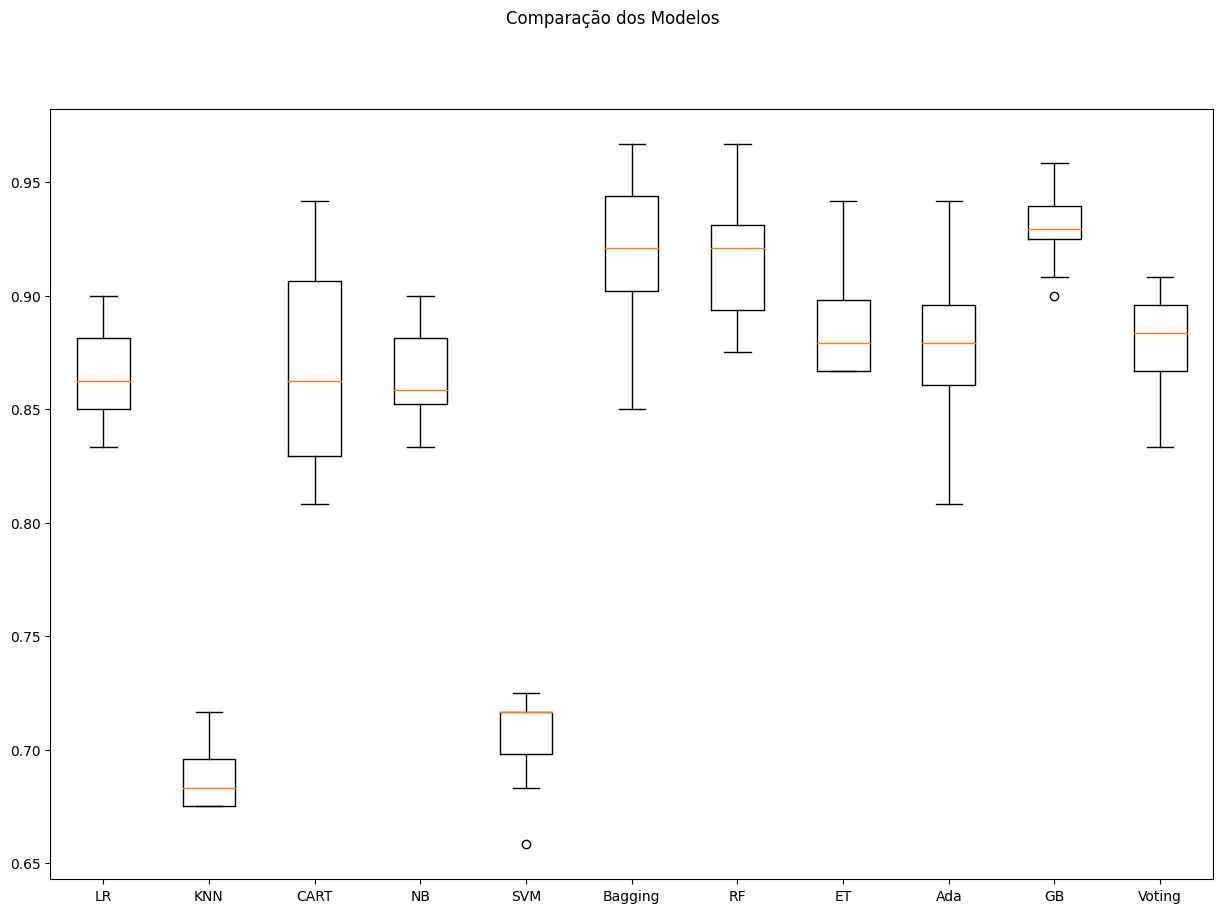

In [ ]:
# Criação e avaliação de modelos: linha base

np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos (treinamento)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Modelos com dados padronizados ou normalizados


Cria-se pipelines para a criação/treinamento de modelos utilizando técnicas de padronização ou normalização dos dados para realizar o pre-processamentos desses dados.  
Em seguida é avaliado novamente o desempenho dos modelos comparando a linha de base com os que tiveram uma padronização dos dados e com aqueles que tiveram uma normalização.  

LR-orig: 0.866 (0.022)
KNN-orig: 0.687 (0.014)
CART-orig: 0.869 (0.043)
NB-orig: 0.865 (0.019)
SVM-orig: 0.707 (0.021)
Bag-orig: 0.917 (0.033)
RF-orig: 0.914 (0.027)
ET-orig: 0.887 (0.023)
Ada-orig: 0.877 (0.033)
GB-orig: 0.929 (0.016)
Vot-orig: 0.878 (0.022)
LR-padr: 0.867 (0.022)
KNN-padr: 0.846 (0.026)
CART-padr: 0.865 (0.038)
NB-padr: 0.865 (0.019)
SVM-padr: 0.875 (0.024)
Bag-padr: 0.919 (0.034)
RF-padr: 0.926 (0.025)
ET-padr: 0.887 (0.023)
Ada-padr: 0.877 (0.033)
GB-padr: 0.929 (0.016)
Vot-padr: 0.888 (0.017)
LR-norm: 0.867 (0.021)
KNN-norm: 0.844 (0.026)
CART-norm: 0.868 (0.041)
NB-norm: 0.865 (0.019)
SVM-norm: 0.865 (0.027)
Bag-norm: 0.918 (0.036)
RF-norm: 0.918 (0.028)
ET-norm: 0.884 (0.032)
Ada-norm: 0.877 (0.033)
GB-norm: 0.929 (0.016)
Vot-norm: 0.887 (0.021)


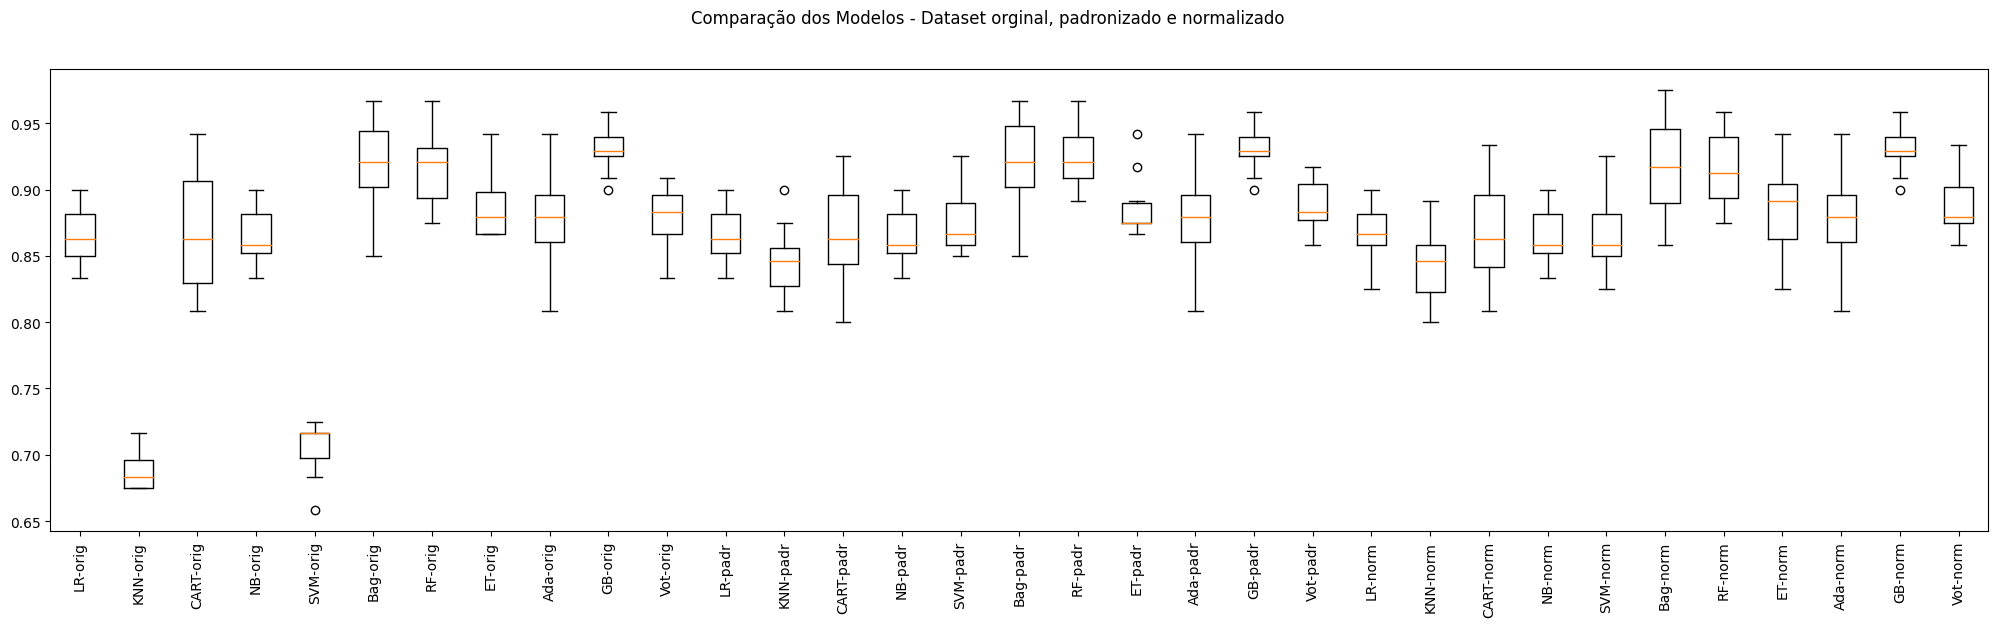

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline
# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Modelos com otimização de hiperparâmetros


Em uma última avaliação, utilizamos o Grid Search para buscarmos os melhores hiperparâmetros de cada modelo, tanto com padronização e com normalização.

In [ ]:
# Otimização dos hiperparâmetros

np.random.seed(7)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Cerca de 1h 15min para executar essa célula

Modelo: LR-orig - Melhor: 0.860833 usando {'LR__C': 1, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.860833 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: LR-norm - Melhor: 0.865000 usando {'LR__C': 1, 'LR__solver': 'liblinear'}
Modelo: KNN-orig - Melhor: 0.716667 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Modelo: KNN-padr - Melhor: 0.851667 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
Modelo: KNN-norm - Melhor: 0.847500 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Modelo: CART-orig - Melhor: 0.900833 usando {'CART__max_depth': 30, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-padr - Melhor: 0.904167 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-norm - Melhor: 0.905000 usando {'CART__max_depth': 20, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: NB-orig - Melhor: 0.856667 usando {'NB__var_smoothing': 1e-09}
Modelo: NB-

## Resultado da avaliação com otimização de hiperparâmetros

Devido ao tempo de execução do GridSearch em cerca de 1h e 15min, reproduz-se aqui o resultado obtido para conferência.  
```
Modelo: LR-orig - Melhor: 0.860833 usando {'LR__C': 1, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.860833 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: LR-norm - Melhor: 0.865000 usando {'LR__C': 1, 'LR__solver': 'liblinear'}
Modelo: KNN-orig - Melhor: 0.716667 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Modelo: KNN-padr - Melhor: 0.851667 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
Modelo: KNN-norm - Melhor: 0.847500 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Modelo: CART-orig - Melhor: 0.900833 usando {'CART__max_depth': 30, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-padr - Melhor: 0.904167 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-norm - Melhor: 0.905000 usando {'CART__max_depth': 20, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: NB-orig - Melhor: 0.856667 usando {'NB__var_smoothing': 1e-09}
Modelo: NB-padr - Melhor: 0.856667 usando {'NB__var_smoothing': 1e-09}
Modelo: NB-norm - Melhor: 0.856667 usando {'NB__var_smoothing': 1e-09}
Modelo: SVM-orig - Melhor: 0.866667 usando {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Modelo: SVM-padr - Melhor: 0.869167 usando {'SVM__C': 100, 'SVM__gamma': 0.001, 'SVM__kernel': 'rbf'}
Modelo: SVM-norm - Melhor: 0.867500 usando {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Modelo: Bagging-orig - Melhor: 0.915000 usando {}
Modelo: Bagging-padr - Melhor: 0.915000 usando {}
Modelo: Bagging-norm - Melhor: 0.912500 usando {}
Modelo: RF-orig - Melhor: 0.920833 usando {'RF__max_depth': 20, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 100}
Modelo: RF-padr - Melhor: 0.920833 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 50}
Modelo: RF-norm - Melhor: 0.921667 usando {'RF__max_depth': 20, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}
Modelo: ET-orig - Melhor: 0.891667 usando {'ET__max_depth': 20, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 2, 'ET__n_estimators': 50}
Modelo: ET-padr - Melhor: 0.891667 usando {'ET__max_depth': None, 'ET__max_features': 'log2', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 2, 'ET__n_estimators': 200}
Modelo: ET-norm - Melhor: 0.890000 usando {'ET__max_depth': 30, 'ET__max_features': 'log2', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 2, 'ET__n_estimators': 200}
Modelo: Ada-orig - Melhor: 0.912500 usando {'Ada__learning_rate': 1, 'Ada__n_estimators': 10}
Modelo: Ada-padr - Melhor: 0.912500 usando {'Ada__learning_rate': 1, 'Ada__n_estimators': 10}
Modelo: Ada-norm - Melhor: 0.912500 usando {'Ada__learning_rate': 1, 'Ada__n_estimators': 10}
Modelo: GB-orig - Melhor: 0.931667 usando {'GB__learning_rate': 0.2, 'GB__max_depth': 7, 'GB__n_estimators': 200}
Modelo: GB-padr - Melhor: 0.932500 usando {'GB__learning_rate': 0.2, 'GB__max_depth': 7, 'GB__n_estimators': 200}
Modelo: GB-norm - Melhor: 0.932500 usando {'GB__learning_rate': 0.3, 'GB__max_depth': 7, 'GB__n_estimators': 100}
Modelo: Voting-orig - Melhor: 0.879167 usando {}
Modelo: Voting-padr - Melhor: 0.885833 usando {}
Modelo: Voting-norm - Melhor: 0.885000 usando {}
```

## Avaliação do modelo com o conjunto de teste

Melhor modelo pelo resultado da avaliação com otimização de hiperparâmetros  
```
Modelo: GB-padr - Melhor: 0.932500 usando {'GB__learning_rate': 0.2, 'GB__max_depth': 7, 'GB__n_estimators': 200}  
Modelo: GB-norm - Melhor: 0.932500 usando {'GB__learning_rate': 0.3, 'GB__max_depth': 7, 'GB__n_estimators': 100}  
```
Como houve um empate em relação ao melhor modelo, será escolhido o modelo com dados padronizados, pois apesar de não fazer diferença em relação a acurácia, preferi utilizar aquele que utilizou o hiperparãmetro `learning-rate` com valor mais próximo a zero, no caso `0.2`. Visto que no meu entendimento, quanto menor esse hiperparâmetro, melhor será sua resistência ao overfitting.  

Aqui é treinado o modelo com os parâmetros escolhidos. Em seguida é realizado o teste com o holdout e avaliado o resultado a acurácia obtida.

In [ ]:
# Avaliação do modelo com o conjunto de testes

np.random.seed(7)

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)

print(accuracy_score(y_test, predictions))

0.9366666666666666


## Pipeline do modelo com os hiperparâmetros otimizados


Realiza a mesma avaliação anterior utilizando uma pipeline para padronizar os dados automaticamente.

In [ ]:
# Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados

np.random.seed(7)

model = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)

pipeline = Pipeline(steps=[('StandardScaler', StandardScaler()), ('GB', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9366666666666666


## Prepara os arquivos para o export

Aqui é preparado os arquivos tanto do Modelo e do padronizador separadamente, quanto uma pipeline contendo o modelo e padronizador. Podendo assim utilizar tanto a pipeline quanto o modelo separadamente.

São preparados os arquivos:  
- Modelo escolhido com hiperparâmetros otimizados - `hr_recruitment_classifier.pkl`  
- Padronizador utilizado - `standard_scaler_recruitment.pkl`  
- Pipeline contendo o modelo e o padronizador - `hr_recruitment_pipeline.pkl`  
- Os dados separados no holdout são exportados para serem utilizados como o golden set do sistema. - `X_test_dataset_hr_recruitment.csv e y_test_dataset_hr_recruitment.csv`  

In [ ]:
# Salvando os arquivos

# Salvando o modelo
model_filename = 'hr_recruitment_classifier.pkl'
with open("/content/files/models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'standard_scaler_recruitment.pkl'
with open("/content/files/scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Salvando o pipeline
pipeline_filename = 'hr_recruitment_pipeline.pkl'
with open("/content/files/pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("/content/files/data/X_test_dataset_hr_recruitment.csv", index=False)
y_test_df.to_csv("/content/files/data/y_test_dataset_hr_recruitment.csv", index=False)
test_df = X_test_df.join(y_test_df)
test_df.to_csv("/content/files/data/test_dataset_hr_recruitment.csv", index=False)

## Export pipelines extras para teste no Back-end do sistema


Para a realizado de alguns testes no Back-end do sistema aqui exportamos dois outros pipelines para a comparação no teste.  
Foram escolhidos o Random Forest que possui acurácia próxima ao modelo escolhido, e também o Extra Trees que possui uma acurácia menor.

In [ ]:
# Pipelines criadas para teste em Back-end

# Modelos escolhidos
# Modelo: RF-norm - Melhor: 0.921667 usando {'RF__max_depth': 20, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}
# Modelo: ET-orig - Melhor: 0.891667 usando {'ET__max_depth': 20, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 2, 'ET__n_estimators': 50}

np.random.seed(7)

model_test_rf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)

pipeline_test_rf = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('RF', model_test_rf)])

pipeline_test_rf.fit(X_train, y_train)
predictions_test_rf = pipeline_test_rf.predict(X_test)

model_test_et = ExtraTreesClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=50)

pipeline_test_et = Pipeline(steps=[('ET', model_test_et)])

pipeline_test_et.fit(X_train, y_train)
predictions_test_et = pipeline_test_et.predict(X_test)

print(accuracy_score(y_test, predictions_test_rf))
print(accuracy_score(y_test, predictions_test_et))

# Prepara arquivos para o export
pipeline_filename_rf = 'hr_recruitment_pipeline_test_randomForrest.pkl'
pipeline_filename_et = 'hr_recruitment_pipeline_test_extraTree.pkl'

with open("/content/files/pipelines/"+pipeline_filename_rf, 'wb') as file:
    pickle.dump(pipeline_test_rf, file)

with open("/content/files/pipelines/"+pipeline_filename_et, 'wb') as file:
    pickle.dump(pipeline_test_et, file)

0.94
0.8833333333333333


## Export dos arquivos

Os arquivos são salvos no sistema local.

In [ ]:
from google.colab import files

files.download("/content/files/models/hr_recruitment_classifier.pkl")
files.download("/content/files/pipelines/hr_recruitment_pipeline.pkl")
files.download("/content/files/scalers/standard_scaler_recruitment.pkl")
files.download("/content/files/data/X_test_dataset_hr_recruitment.csv")
files.download("/content/files/data/y_test_dataset_hr_recruitment.csv")
files.download("/content/files/data/test_dataset_hr_recruitment.csv")
files.download("/content/files/pipelines/hr_recruitment_pipeline_test_randomForrest.pkl")
files.download("/content/files/pipelines/hr_recruitment_pipeline_test_extraTree.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusão


Em uma observação final, destaco que, apesar de uma pequena diferença que pode até ser desconsiderada (menor que 1%), o segundo melhor modelo na avaliação com a otimização de hiperparâmetros (Random Forest), acabou apresentando uma melhor acurácia com o holdout de teste. Mesmo assim, preferi manter a escolha do Gradient Booster como modelo base por ele ter se mostrado mais consistente ao longo de todas as avaliações feitas.

As pipelines com o Random Forest e Extra Trees serão utilizadas apenas em teste automatizados.


## Especificações Modelo Final

- Modelo de Base: **Gradient Booster**
- Pré-processamento: **Standard Scaler**
- Hiperparâmetros: **learning_rate=0.2, max_depth=7, n_estimators=200**
